<a href="https://colab.research.google.com/github/krauseannelize/nb-ml-ms-exercises/blob/main/notebooks/05_ml_model_adult_income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05 | ML Model: Adult Income

# Feature Preparation

In this exercise, the feature preparation steps is practiced using the [Adult Income Dataset](https://archive.ics.uci.edu/dataset/2/adult) from the **UCI Machine Learning Repository**.

## About the Dataset

- **Size:** 32561 rows, 15 columns
- **Target column:** `Income`
- **Goal prediction:** Whether a person earns `>50K` or `<=50K` per year
- **Missing values:** Represented by `" ?"` which will be replaced with null values when the dataset is read


## Load the Dataset

In [1]:
# Import pandas for data handling
import pandas as pd

# Define the dataset URL from the UCI Machine Learning Repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Define column names for the dataset that does not inclue headers
columns = [
    "age","workclass","fnlwgt","education","education-num","marital-status",
    "occupation","relationship","race","sex","capital-gain","capital-loss",
    "hours-per-week","native-country","income"
]

# Load the dataset into a DataFrame:
# - names=columns assigns the headers
# - na_values=" ?" treats " ?" as missing values
# - sep="," splits on commas
# - engine="python" allows regex separators
df = pd.read_csv(url, header=None, names=columns, na_values=" ?", sep=",", engine="python")

# Preview the first 5 rows of the dataset
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [2]:
# Inspect shape of the dataset
print(f"Dataset shape\nRows: {df.shape[0]}\nColumns: {df.shape[1]}")

Dataset shape
Rows: 32561
Columns: 15


In [3]:
# View column data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [4]:
# Create a copy of the dataset to commence cleaning
df_clean = df.copy()

## Step 1 | Handling Missing Values

Tasks:

- Identify which columns contain missing values.
- Decide: should you drop rows/columns, or impute (fill in) the values?
- If imputing, what strategy makes sense for numeric vs categorical features?

### 1.1 Check for Missing Values

In [5]:
# Check DataFram for missing values
df_clean.isnull().sum()

,0
age,0
workclass,1836
fnlwgt,0
education,0
education-num,0
marital-status,0
occupation,1843
relationship,0
race,0
sex,0


### 1.2 Dropping Missing Values

In [6]:
# Subset of columns with missing values
cols_with_na = ['workclass', 'occupation', 'native-country']

# See how many rows are missing values in a combination of these columns
df_clean[cols_with_na].isnull().sum(axis=1).value_counts()

,count
0,30162
2,1809
1,563
3,27


Only 27 rows are missing values in `workclass`, `occupation` and `native-country` and represent a negligible percentage of data. These rows can safely be dropped.

In [7]:
# Print shape of dataset before droppin for comparison
print("Original shape:", df_clean.shape)

# Drop rows where all three columns have missing values
df_clean.dropna(subset=cols_with_na, how='all', inplace=True)

# Print shape of dataset after dropping for confirmation
print("New shape after dropping 27 rows:", df_clean.shape)

Original shape: (32561, 15)
New shape after dropping 27 rows: (32534, 15)


### 1.3 Imputing Missing Values

Since all columns with missing values are categorical, the next step is to examine the distribution of existing categories. This will help guide the imputation strategy:

1. **Add an "Unknown" category:** Preserves missingness as its own signal, which may be informative for the model.
2. **Impute with the most frequent value (mode):** Fills gaps with the dominant category, but risks skewing the distribution if one class is already overrepresented.

In [8]:
# Look at value counts for each column with missing values
for col in ['workclass', 'occupation', 'native-country']:
    print(f"\n--- {col.upper()} ---")
    print(df_clean[col].value_counts(dropna=False).sort_values(ascending=False))


--- WORKCLASS ---
workclass
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
NaN                   1809
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: count, dtype: int64

--- OCCUPATION ---
occupation
 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
NaN                   1816
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: count, dtype: int64

--- NATIVE-COUNTRY ---
native-country
 United-States                 29170
 Mexico                          643
NaN                              556
 Philippines                     198
 Germany                         137
 Canada         

The `workclass` column is dominated by the "Private" category. Using mode to impute would just further inflate that dominance further. In this instance, the better choice is imputing a new category "Unknown" so the model can learn that missingness itself might be informative.

In [9]:
# Impute `workclass` with "Unknown"
df_clean['workclass'] = df_clean['workclass'].fillna('Unknown')

The distribution in the `occupation` column is fairly close in frequency. With 1816 rows missing values, using mode to impute the category with the highest frequency "Prof-specialty" would artificially inflate it above the other, would distort the balance. To avoid biasing the distribution, the better choice again is to impute a new category "Unknown" so the model can decide if the missingness is predictive.

In [10]:
# Impute `occupation` with "Unknown"
df_clean['occupation'] = df_clean['occupation'].fillna('Unknown')

The `native-country` column is is overwhelmingly represented by the "United-States" category. Because of this imbalance, imputing missing values with the mode would have little to no impact on the overall distribution.

In [11]:
# Impute `native-country` with highest frequency value using mode
df_clean['native-country'] = df_clean['native-country'].fillna(df_clean['native-country'].mode()[0])

In [12]:
# Recheck DataFrame for missing values to confirm
df_clean.isnull().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
education-num,0
marital-status,0
occupation,0
relationship,0
race,0
sex,0


### 1.4 Dropping Entire Columns

The `fnlwgt` (final weight) column is a survey sampling weight, not a feature describing the individual. It is not predictive in ML context so this column is dropped.

In [13]:
# Drop `fnlwgt` column
df_clean.drop('fnlwgt', axis=1, inplace=True)

The `education-num` column is the numeric encoding of the `education` column. To avoid redundance, the `education` column can safely be dropped.

In [14]:
# Drop `education` column
df_clean.drop('education', axis=1, inplace=True)

## Step 2 | Handling Outliers

Tasks:

- Explore the numeric features.
- Use summary statistics and visualizations (e.g., histograms, boxplots) to detect extreme values.
- Apply the **IQR method** or another method to set thresholds.
- Decide: remove, cap, or transform outliers.

In [15]:
# View summary statistics of the numeric columns in the DataFrame
df_clean.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,32534.000000,32534.000000,32534.000000,32534.000000,32534.000000
mean,38.581976,10.080593,1078.079240,87.274974,40.443690
std,13.638271,2.572388,7388.178272,402.934330,12.344959
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


### 2.1 Visualize Outliers

- `age` range from 17-90, which is realistic. Outliers are unlikely.
- `education-num` range from 1-16, representing years of education. These values are bounded and realistic, so outliers are unlikely.
- `capital-gain` ranges from 0 to 99,999 and is highly skewed, with most values at zero and a few very large numbers. Rather than treating these as outliers, it may be more useful to transform or recast this feature.
- `capital-loss` ranges from 0 to 4,356 and is highly skewed, with most values at zero and a few very large numbers. Rather than treating these as outliers, it may be more useful to transform or recast this feature.
- `hours-per-week` ranges from 0 to 99, which is unrealistic. Outliers are very likely.

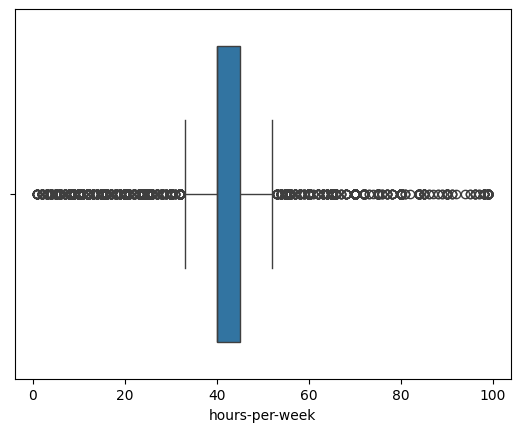

In [16]:
# Import seaborn for data visualization and plotting
import seaborn as sns

# Visualize outliers in hours-per-week column with a boxplot
sns.boxplot(x=df_clean["hours-per-week"]);

**Observation:** Most individuals work between 35 and 50 hours per week, but numerous extreme outliers extend down to 0 and up to 99 hours.

### 2.2 Detect Outliers Using IQR

In [17]:
# Calculate the 1st and 3rd quartiles of the hours-per-week column
Q1 = df_clean["hours-per-week"].quantile(0.25)
Q3 = df_clean["hours-per-week"].quantile(0.75)

# Calculate the interquartile range
IQR = Q3 - Q1

# Define lower and upper bounds for outlier detection
# Using 3*IQR instead of 1.5*IQR to relax the outlier definition
# 1.5*IQR bounds: 32.5–52.5 - flags too many valid cases
# 3*IQR bounds: 25–60 - captures only the most extreme values

lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Filter rows to view outliers
outliers = df_clean[(df_clean["hours-per-week"] < lower_bound) | (df_clean["hours-per-week"] > upper_bound)]
print(f"Number of outliers in hours-per-week: {len(outliers)}")

Number of outliers in hours-per-week: 4372


### 2.3 Capping Outliers

Given the large number of extreme values in hours-per-week, I will proceed with capping rather than removing rows. This approach allows me to retain all observations while reducing the influence of unrealistic extremes on the analysis.

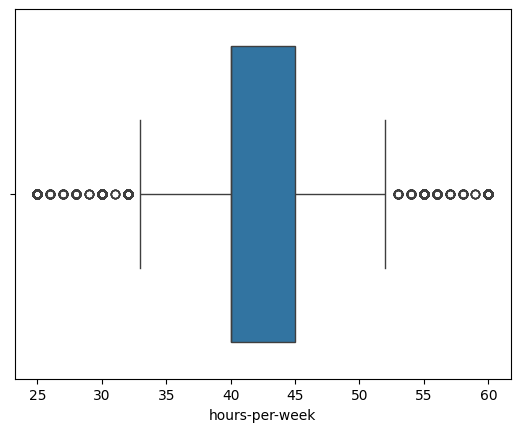

In [18]:
# Use previously defined bounds to cap outliers
df_clean["hours-per-week"] = df_clean["hours-per-week"].clip(lower=lower_bound, upper=upper_bound)

# Visualize capped data - semicolon added to suppress text output
sns.boxplot(x=df_clean["hours-per-week"]);

## Step 3 | Handling Categorical Data

Tasks:

- Find all the categorical features in the dataset.
- Convert them into numeric form so they can be used in models.
- Try both `pd.get_dummies()` and `OneHotEncoder`.
- Reflect: which method would you use in production, and why?

In [19]:
df_clean.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,25,United-States,<=50K
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### 3.1 Label Encoding (Binary Categories)

Convert `sex` and `income` to binary variables since both contain only two categories, making them simpler and more efficient for modeling. Because the distributions of `capital-gain` and `capital-loss` are highly skewed, treating them as continuous features adds little signal. Instead, they are converted to binary indicators (0 = no gain/loss, 1 = some gain/loss) to reduce noise and streamline the model.

In [20]:
# Check different values and distributions in sex column
df_clean["sex"].value_counts()

,count
sex,
Male,21778
Female,10756


In [21]:
# Replace male with 0 and female with 1
df_clean["sex"] = df_clean["sex"].str.strip()
df_clean["sex"] = df_clean["sex"].map({"Male": 0, "Female": 1})

In [22]:
# Recheck different values and distributions in sex column
df_clean["sex"].value_counts()

,count
sex,
0,21778
1,10756


In [23]:
# Check different values and distributions in income column
df_clean["income"].value_counts()

,count
income,
<=50K,24697
>50K,7837


In [24]:
# Replace <=50K with 0 and >50K with 1
df_clean["income"] = df_clean["income"].str.strip()
df_clean["income"] = df_clean["income"].map({"<=50K": 0, ">50K": 1})

In [25]:
# Recheck different values and distributions in income column
df_clean["income"].value_counts()

,count
income,
0,24697
1,7837


In [26]:
# Convert all values larger than 0 to 1 (0 = no gain/loss, 1 = some gain/loss)
df_clean["capital-gain"] = (df_clean["capital-gain"] > 0).astype(int)
df_clean["capital-loss"] = (df_clean["capital-loss"] > 0).astype(int)

In [27]:
# Preview dataset
df_clean.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,0,1,0,40,United-States,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,0,0,0,25,United-States,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,0,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,0,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,1,0,0,40,Cuba,0


### 3.2 OneHotEncoder with `scikit-learn`

In [28]:
# Import OneHotEncoder from scikit-learn for categorical encoding
from sklearn.preprocessing import OneHotEncoder

# Subset of columns with categorical values
cat_cols = ["workclass", "marital-status", "occupation", "relationship", "race", "native-country"]

# Create a OneHotEncoder object from `scikit-learn`
encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")

# Use fit_transform to learn which categories exist and create new columns for each category
encoded_cat = encoder.fit_transform(df_clean[cat_cols])

# Create dataframe with encoded columns
df_encoded = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(cat_cols), index=df_clean.index)

# Drop original categorical columns and add encoded ones
df_clean = df_clean.drop(columns=cat_cols)
df_clean = pd.concat([df_clean, df_encoded], axis=1)

# Preview the updated dataframe after encoding
df_clean.head()

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,income,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,13,0,1,0,40,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,50,13,0,0,0,25,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,38,9,0,0,0,40,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,53,7,0,0,0,40,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28,13,1,0,0,40,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 4 | Feature Scaling

Tasks:

- Pick several numeric features.
- Apply **different scaling methods** (Min-Max, Standardization).
- Compare before and after.
- Which method do you think is most appropriate here?

### 4.1 Normalization (Min-Max Scaling)

In [29]:
# Summarize to see if it makes sense to scale continuous variables age, education-num and hours-per-week
df_clean[["age", "education-num", "hours-per-week"]].describe()

,age,education-num,hours-per-week
count,32534.000000,32534.000000,32534.000000
mean,38.581976,10.080593,40.851632
std,13.638271,2.572388,9.107241
min,17.000000,1.000000,25.000000
25%,28.000000,9.000000,40.000000
50%,37.000000,10.000000,40.000000
75%,48.000000,12.000000,45.000000
max,90.000000,16.000000,60.000000


These are very different scaling and, without scaling, a comparison between `age`, `education-num` and `hours-per-week` would be unfair.

In [30]:
# Import MinMaxScaler from scikit-learn for feature scaling
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler (default scales features to range [0, 1])
scaler = MinMaxScaler()

# Work on a copy of the DataFrame to preserve the original
df_minmax = df_clean.copy()

# Fit the scaler on `age`, `education-num` and `hours-per-week`
# and transform them into the [0, 1] range
df_minmax[["age", "education-num", "hours-per-week"]] = scaler.fit_transform(df_minmax[["age", "education-num", "hours-per-week"]])

# Summarize scaled features to confirm new range and distribution
df_minmax[["age", "education-num", "hours-per-week"]].describe()

,age,education-num,hours-per-week
count,32534.000000,32534.000000,32534.000000
mean,0.295644,0.605373,0.452904
std,0.186826,0.171493,0.260207
min,0.000000,0.000000,0.000000
25%,0.150685,0.533333,0.428571
50%,0.273973,0.600000,0.428571
75%,0.424658,0.733333,0.571429
max,1.000000,1.000000,1.000000


### 4.2 Standardization (Z-score)

In [31]:
# Import StandardScaling from scikit-learn for feature scaling
from sklearn.preprocessing import StandardScaler

# Initialize the scaler (standardizes features to mean=0, std=1)
scaler = StandardScaler()

# Work on a copy of the DataFrame to preserve the original
df_standard = df_clean.copy()

# Fit the scaler on `age`, `education-num` and `hours-per-week`
# and transform them to standardized values
df_standard[["age", "education-num", "hours-per-week"]] = scaler.fit_transform(df_standard[["age", "education-num", "hours-per-week"]])

# Summarize standardized features (rounded) to confirm mean≈0 and std≈1
df_standard[["age", "education-num", "hours-per-week"]].describe().round(2)

,age,education-num,hours-per-week
count,32534.00,32534.00,32534.00
mean,0.00,0.00,0.00
std,1.00,1.00,1.00
min,-1.58,-3.53,-1.74
25%,-0.78,-0.42,-0.09
50%,-0.12,-0.03,-0.09
75%,0.69,0.75,0.46
max,3.77,2.30,2.10


## Step 5 | Feature Engineering

- Create at least **two new features** that could help predict income.
- Think about combinations, transformations, or new groupings of existing variables.
- Explain your reasoning: why might these new features help?

### 5.1 Feature Creation | Working Hours Category

Bucket hours-per-week into categories such as part-time (<35), full-time (35–40), and overtime (>40).

In [32]:
# Define function that categorized hours-per-week
def work_hours_category(x):
    if x < 35:
        return "part-time"
    elif x <= 40:
        return "full-time"
    else:
        return "overtime"

df_clean["work-hours-cat"] = df_clean["hours-per-week"].apply(work_hours_category)

In [33]:
# Preview `hours-per-week` and new feature `work-hours-cat`
df_clean[["hours-per-week", "work-hours-cat"]].head()

,hours-per-week,work-hours-cat
0,40,full-time
1,25,part-time
2,40,full-time
3,40,full-time
4,40,full-time


### 5.2 Binning | Age Groups

Bin age into groups (e.g., 18–29, 30–44, 45–60, 60+).

In [34]:
# Create bins and labels
bins = [17, 29, 44, 60, 100]
labels = ["young", "mid-career", "senior", "retired"]

# Add new feature `age-group` categorizing `age` into defined bins and labels
df_clean["age-group"] = pd.cut(df_clean["age"], bins=bins, labels=labels, right=False)

# Preview `age` and new feature `age-group`
df_clean[["age", "age-group"]].head()

,age,age-group
0,39,mid-career
1,50,senior
2,38,mid-career
3,53,senior
4,28,young


# Logistic Regression

## Step 0 | Check the Dataset

In [35]:
# Preview the processed dataset
df_clean.head()

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,income,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,work-hours-cat,age-group
0,39,13,0,1,0,40,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,full-time,mid-career
1,50,13,0,0,0,25,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,part-time,senior
2,38,9,0,0,0,40,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,full-time,mid-career
3,53,7,0,0,0,40,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,full-time,senior
4,28,13,1,0,0,40,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,full-time,young


### Issues

- `work-hours-cat` and `age-group` are still in text.
- The need to be encoded as models can't use strings.

### Tasks

- `work-hours-cat`: Ordinal/label encode
  - Map the ordered groups to integers (e.g., part-time < full-time < overtime).
 - `age-group`: Ordinal/label encode
Map the ordered groups to integers (e.g., young < mid-career < senior < retired)

### `work-hours-cat` | Ordinal Encoding

In [36]:
# Define a mapping from categorical work hours category to numeric codes
work_hours_mapping = {"part-time": 0, "full-time": 1, "overtime": 2}

# Apply mapping to create a new numeric "work-hours-cat-num" column
df_clean["work-hours-cat-num"] = df_clean["work-hours-cat"].map(work_hours_mapping).astype("Int64")

# Preview dataset to confirm new numeric column
df_clean.head()

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,income,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,work-hours-cat,age-group,work-hours-cat-num
0,39,13,0,1,0,40,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,full-time,mid-career,1
1,50,13,0,0,0,25,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,part-time,senior,0
2,38,9,0,0,0,40,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,full-time,mid-career,1
3,53,7,0,0,0,40,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,full-time,senior,1
4,28,13,1,0,0,40,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,full-time,young,1


### `age-group` | Ordinal Encoding

In [37]:
# Define a mapping from categorical age groups to numeric codes
age_group_mapping = {"young": 0, "mid-career": 1, "senior": 2, "retired": 3}

# Apply mapping to create a new numeric "age-group-num" column
df_clean["age-group-num"] = df_clean["age-group"].map(age_group_mapping).astype("Int64")

# Preview dataset to confirm new numeric column
df_clean.head()

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,income,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,work-hours-cat,age-group,work-hours-cat-num,age-group-num
0,39,13,0,1,0,40,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,full-time,mid-career,1,1
1,50,13,0,0,0,25,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,part-time,senior,0,2
2,38,9,0,0,0,40,0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,full-time,mid-career,1,1
3,53,7,0,0,0,40,0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,full-time,senior,1,2
4,28,13,1,0,0,40,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,full-time,young,1,0


### Drop Columns

In [38]:
# Drop colums that have been replaced with engineered versions
# Assign to new DataFrame to keep original in tact
df_lr = df_clean.drop(columns=["age", "hours-per-week", "work-hours-cat", "age-group"])

# Preview updated DataFrame to confirm all columns numerical
df_lr.head()

,education-num,sex,capital-gain,capital-loss,income,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,work-hours-cat-num,age-group-num
0,13,0,1,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1
1,13,0,0,0,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,2
2,9,0,0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1
3,7,0,0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,2
4,13,1,0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


## Step 1 | Split Features (X) and Target (y)

- **Features (X):** Column used to predict income
- **Target (y):** Column to predict → `income`

In [39]:
# Features: all but the target
X = df_lr.drop(columns=["income"])

# Target column
y = df_lr["income"]

# Quick check to confirm 'income' not included to prevent data leakage
X.head()

,education-num,sex,capital-gain,capital-loss,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,...,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,work-hours-cat-num,age-group-num
0,13,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1
1,13,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,2
2,9,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1
3,7,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,2
4,13,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


## Step 2 | Split into Train/Test

In [40]:
# Import function to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split features (X) and target (y) into train and test sets
# - test_size=0.2 → 20% of the data goes to the test set
# - random_state=42 → ensures reproducibility of the split
# - stratify=y → keeps the same class distribution in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Print the shape of the resulting datasets to verify the split
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (26027, 83)
Test size: (6507, 83)


## Step 3 | Choose an Algorithm

In [41]:
# Import LogisticRegression model from scikit-learn
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
# - max_iter=1000 → increases the maximum number of iterations so the solver has enough time to converge
# - random_state=42 → ensures reproducibility of results
model = LogisticRegression(max_iter=1000, random_state=42)

# View untrained algorithm object
model

LogisticRegression(max_iter=1000, random_state=42)

## Step 4 | Fit the Model

In [42]:
# Train (fit) the logistic regression model on the training data
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [43]:
# Print the learned coefficients for each feature
# These represent the weight/importance of each input variable
print(model.coef_)

[[ 2.82396100e-01 -7.96189742e-01  1.68210610e+00  1.14432197e+00
  -7.69277410e-01 -1.14075047e-02 -5.39592888e-01 -2.59516497e-01
  -9.86620423e-01 -8.24204656e-01 -1.36048523e+00 -5.62469533e-01
   1.65109079e+00  1.70221411e+00  1.76133867e-04 -4.48205514e-01
  -8.74494348e-02  2.34172818e-01 -3.20801447e-01  7.48939771e-02
   7.68683278e-01 -7.82977649e-01 -7.01065937e-01 -3.86121536e-01
  -8.64535362e-01 -1.64528211e+00  5.49055475e-01  5.74504081e-01
   1.99531067e-01  6.39325575e-01 -8.65350678e-02 -5.73877038e-01
   1.35638322e-01 -5.26931265e-01 -9.50771659e-01 -7.21649168e-02
   1.39731105e+00  5.39510524e-01  4.22605886e-01  2.38242050e-01
   5.29375303e-01  4.14007840e-01 -5.90942604e-01 -1.33705730e+00
   4.26560668e-01 -8.62952182e-01  7.14090210e-02 -2.38120454e-01
   5.64975021e-01  2.93451147e-01  5.31604879e-01 -9.19374779e-01
  -1.19656534e-01 -7.96984874e-01  0.00000000e+00 -1.68815303e-01
  -2.94825321e-01 -4.16880027e-01 -6.87312782e-02 -1.76730000e-02
   3.34437

In [44]:
# Print the intercept (bias term) of the model
# This shifts the decision boundary
print(model.intercept_)

[-6.94727454]


## Step 5 | Predict with Test Data

### Predict Class Labels (0 or 1)

In [45]:
# Predict class labels 0 (<=50K) or 1 (>50K)
y_pred = model.predict(X_test)
print(y_pred[:10])

[0 1 0 0 0 0 0 0 1 0]


### Predict Probabilities

In [46]:
# Predict probability of income
y_proba = model.predict_proba(X_test)
print(y_proba[:10])

[[0.98578359 0.01421641]
 [0.20092505 0.79907495]
 [0.92431299 0.07568701]
 [0.99484314 0.00515686]
 [0.70782524 0.29217476]
 [0.81493889 0.18506111]
 [0.85152302 0.14847698]
 [0.84427673 0.15572327]
 [0.23515723 0.76484277]
 [0.99123757 0.00876243]]


**Understanding the output:**

- _Column 0:_ probability of class 0 (<=50K)
- _Column 1:_ probability of class 1 (>50K)

Example:

- _Adult 1:_ `[0.98, 0.01]` → 1% chance earn >50K (0)
- _Adult 2:_ `[0.20, 0.79]` → 79% chance earn >50K (1)

### Put Everything Together

In [60]:
import pandas as pd

# Create a DataFrame to compare actual vs. predicted results
# - Actual: real income (0/1)
# - Predicted: income predicted (0/1)
# - Prob_Income: predicted probability of income
results = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred,
    "Prob_Income": y_proba[:, 1]
})

# Preview the comparison
results.head(10)

,Actual,Predicted,Prob_Income
0,0,0,0.014216
1,1,1,0.799075
2,0,0,0.075687
3,0,0,0.005157
4,0,0,0.292175
5,0,0,0.185061
6,0,0,0.148477
7,0,0,0.155723
8,0,1,0.764843
9,0,0,0.008762


Here we can:

- spot cases where the model was confident (probabilities close to 0 or 1), and
- spot borderline cases (probabilities around 0.5).

## Step 6 | Evaluate

In [61]:
from sklearn.metrics import accuracy_score

# Compare true values (y_test) vs predicted values (y_pred)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)

Accuracy: 0.8421699708006762


The model correctly predicted income for 84% of the adults in the test set. It was not necessary to adjust the Logistic Regression threshold as accuracy is high with the default `0.5 threshold`.